In [14]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from io import StringIO 
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [15]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

# [Стекинг и блендинг](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking)

Термины "стекинг" и "блендинг" иногда используют как синонимы (что не совсем корректно). Блендинг можно считать упрощенным вариантом стекинга.

## Краткое описание метода

Во всех ансамблевых моделях явно или неявно используется модель верхнего уровня. В стекинге для такой модели используется явное название **мета-ученик (meta-learner)** или **модель 2 уровня (level 2 model)**.

В моделях на основе бэггинга (бэггинг, случайный лес, сверхслучайные деревья) в качестве модели 2 уровня используется усреднение результатов голосования моделей.

В моделях на основе бустинга используется взвешенная сумма результатов голосования моделей. Бустинг может рассматриваться как разновидность линейной регресии, где регрессорами являются выходы "слабых моделей".

Стекинг принципиальноо отличается от моделей на основе бэггинга и бустинга следующим:
1. Мета-ученик является отдельной моделью машинного обучения, 
выходы "слабых моделей" рассматриваются как входные признаки 
для мета-ученика.

1. В качестве "слабых моделей" рассматриваются различные модели, которые дают различные результаты. (Напомним, что в бэггинге использовались различные выборки, но одинаковая модель). Эти результаты рассматриваются как входные признаки для мета-ученика. 

Идея стекинга показана на следующем рисунке:

Модели 1 уровня обычно сложные и использующие различные алгоритмы, например SVM, дерево решений, случайный лес и т.д. Использование различных алгоритмов, фактически, обеспечивает дисперсию внутри модели, а также исключает возможность возникновения линейной зависимости между признаками, поступающими на вход модели 2 уровня.

Модели 2 уровня обычно простые. Часто используются линейные модели. Например для задачи регрессии - линейная регрессия, для задачи классификации - логистическая регрессия. 

Концепции стекинга и блендинга очень детально рассмотрены в [блоге профессора Александра Геннадьевича Дьяконова.](https://dyakonov.org/2017/03/10/c%d1%82%d0%b5%d0%ba%d0%b8%d0%bd%d0%b3-stacking-%d0%b8-%d0%b1%d0%bb%d0%b5%d0%bd%d0%b4%d0%b8%d0%bd%d0%b3-blending/)

## Эксперименты

В scikit-learn данная модель не реализована напрямую. Она реализована в библиотеке [heamy.](https://heamy.readthedocs.io/en/latest/)

In [16]:
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [17]:
boston = load_boston()
boston_X, boston_y = boston['data'], boston['target']
boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(
    boston_X, boston_y, test_size=0.2, random_state=1)

/Users/ivan/Documents/ТМО/NIR/venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Californi

In [18]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(boston_X_train, boston_y_train)
    y_pred = model.predict(boston_X_test)
    result = mean_absolute_error(boston_y_test, y_pred)
    print(model)
    print('MAE={}'.format(result))

In [19]:
# Точность на отдельных моделях
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=50)
]:
    val_mae(model)
    print('==========================')
    print()

LinearRegression()
MAE=3.7507121808389092

DecisionTreeRegressor()
MAE=3.203921568627451

RandomForestRegressor(n_estimators=50)
MAE=2.233843137254902



In [20]:
# Используем библиотеку heamy
# набор данных
dataset = Dataset(boston_X_train, boston_y_train, boston_X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [21]:
# Эксперимент 1
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.245733599517174, 2.4061724361207695, 2.4107353165273437, 3.1452806878347124, 3.0098795395433777, 2.740213455830461, 2.9919362330106702, 2.151341730695701, 2.5075100237484866, 3.148634398808176]
Mean accuracy: 2.675743742163687
Standard Deviation: 0.35930185275793886
Variance: 0.12909782139528755


In [22]:
# Эксперимент 2
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: случайный лес

stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.3017804878048778, 2.3164878048780473, 2.538560975609754, 3.3315365853658525, 2.8369500000000007, 2.8315750000000026, 2.544274999999998, 2.16345, 2.6730499999999964, 2.5938750000000037]
Mean accuracy: 2.6131540853658537
Standard Deviation: 0.3186426762755424
Variance: 0.10153315514404009


In [23]:
# Эксперимент 3
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [1.6202737770158349, 2.234874322447637, 2.0768051191634593, 3.101182250739759, 2.4345084063710187, 2.0297129567630563, 2.3429488137539076, 2.1272193381974303, 2.0114520265785787, 2.403459218323834]
Mean accuracy: 2.238243622935452
Standard Deviation: 0.3656020572129594
Variance: 0.13366486423834806


In [24]:
# Эксперимент 4
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: случайный лес
# Результат хуже чем в эксперименте 3
stacker = Regressor(dataset=stack_ds3, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.139707317073167, 2.4460731707317094, 2.2280975609756077, 3.0881951219512205, 2.7481999999999993, 2.1633250000000013, 2.316524999999996, 2.228574999999997, 2.176725000000002, 2.454150000000003]
Mean accuracy: 2.39895731707317
Standard Deviation: 0.2897281433326167
Variance: 0.0839423970389653


In [25]:
# Результаты
array_labels = ['LR','TREE', 'RF', 'TREE+LR=>LR', 
                'TREE+LR=>RF', 'TREE+LR+RF=>LR', 'TREE+LR+RF=>RF']
array_mae = [3.7507121808389168, 2.942156862745098, 2.263039215686275, 
             2.6766504031924305, 2.6775473780487804, 2.2998386142710823, 
             2.406510426829268]

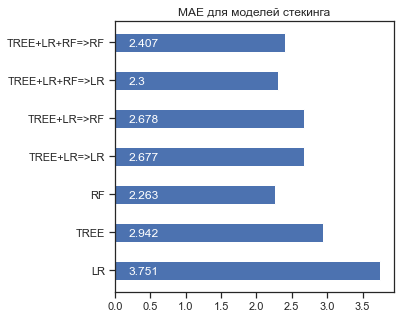

In [26]:
# Визуализация результатов
vis_models_quality(array_mae, array_labels, 'MAE для моделей стекинга')

Вывод: лучший результат стекинга сравним с наиболее сильной моделью 1 уровня (случайным лесом).

В сообществе анализа данных существует афоризм, что "стекинг - не технология серебряной пули, а технология последней мили".

За счет того, что модель стекинга слабо поддается интерпертации, в основном эта модель используется тогда, когда нужно улучшить качество модели на конкретном наборе данных. Например, в соревнованиях по анализу данных.

## Дополнительные источники
- [Блог Александра Дьяконова. Cтекинг (Stacking) и блендинг (Blending)](https://dyakonov.org/2017/03/10/c%d1%82%d0%b5%d0%ba%d0%b8%d0%bd%d0%b3-stacking-%d0%b8-%d0%b1%d0%bb%d0%b5%d0%bd%d0%b4%d0%b8%d0%bd%d0%b3-blending/)
- https://neurohive.io/ru/osnovy-data-science/ansamblevye-metody-begging-busting-i-steking/
- https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/